In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import scipy
from scipy.stats import norm
import tensorflow_probability as tfp
import seaborn as sns
import pandas as pd
import corner 
import math as m
import copy

tfd=tfp.distributions

In [2]:
def draw(base, position = None, ax = None,R = 100):
    ## function to plot the geometry
    if ax == None:
        f,ax=plt.subplots()
        
    if position is not None:

        t = tf.convert_to_tensor(thickness,dtype = tf.float32)

        ps2 = position-t
        
        ps2 = tf.reverse(ps2,[-1])
        
        for i in tf.range(2,Number_para+2): ## lower layer
            base[i].assign([base[i][0],ps2[i-2]])

        for i in tf.range(Number_para+6,2*Number_para+6): ## upper layer
            base[i].assign([base[i][0],position[i-Number_para-6]])

    x = base[:,0]
    z = base[:,1]
    for i in range(base.shape[0]):
        ax.plot(x[i:i+2],z[i:i+2],'k-')
    x_ = np.linspace(-R,R,10)
    ax.plot(x_,np.zeros(np.shape(x_)),lw = 0.5)# draw a reference line, surface
    ax.plot([x[0],x[-1]],[z[0],z[-1]],'k-')
    ax.set_ylim(base[tf.argmin(base[:,1])][1].numpy()-10,5)
    ax.set_xlim(-R,R)
    
    
pi = tf.constant(m.pi) # define PI in Tensorflow form

In [3]:
def draw_MCMC(base,samples,Truth = None,ax = None,R = 70):
    
    if ax == None:
        f,ax=plt.subplots()
    
    if Truth is not None:
        draw(base,Truth,ax = ax, R = R)
            
    x1 = np.linspace(-R,R,Number_para)

    t = tf.convert_to_tensor(thickness,dtype = tf.float32)
    for ps in samples:
        ps2 = ps-t

        ps2 = tf.reverse(ps2,[-1])

        for i in tf.range(2,Number_para+2): ## lower layer
            base[i].assign([base[i][0],ps2[i-2]])

        for i in tf.range(Number_para+6,2*Number_para+6): ## upper layer
            base[i].assign([base[i][0],ps[i-Number_para-6]])

        for i in range(Number_para+5,base.shape[0]-2):
            ax.plot(base[:,0][i:i+2],base[:,1][i:i+2],'r-',alpha = 0.01)
    
    ax.plot(x1,np.zeros(np.shape(x1)),lw = 0.5)# draw a reference line, surface

    ax.set_ylim(base[tf.argmin(base[:,1])][1].numpy()-10,5)
    ax.set_xlim(-R,R)

In [12]:
depth = -20
thickness = 20

corners=np.array([[-200,depth-thickness],
                  [-70,depth-thickness],
                  [70,depth-thickness],# bottom left coner
              [200,depth-thickness], 
              [200,depth], # bottom right coner
              [70, depth], # top right coner
              [-70,depth],# top left coner
              [-200,depth]])
Number_para = 3
obs_N = 9
points = np.empty((2*Number_para+8,2),dtype = np.float32)

points[0] = corners[0]
points[1] = corners[1]

for i in range(6):
    points[Number_para+i] = corners[i]
    
points[-2]=corners[-2]
points[-1]=corners[-1]

np.random.seed(21)

x2 = np.linspace(-70,70,Number_para+2)
x1 = np.linspace(70,-70,Number_para+2)

thickness = 20
y1 = np.random.uniform(-2,-50,Number_para)
y2 = y1-thickness

y1 = list(reversed(y1))

for i in range(2,Number_para+2): ## lower layer
    points[i][1] = y2[i-2]
    points[i][0] = x2[i-1]
    
for i in range(Number_para+6,2*Number_para+6): ## upper layer
    points[i][1] = y1[i-Number_para-6]
    points[i][0] = x1[i-Number_para-5]


(-70, 70)

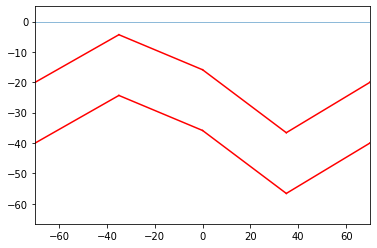

In [13]:
# Draw Base
f,ax=plt.subplots()
x = points[:,0]
z = points[:,1]
for i in range(points.shape[0]):
    ax.plot(x[i:i+2],z[i:i+2],'r-')
x_ = np.linspace(-70,70,10)
ax.plot(x_,np.zeros(np.shape(x_)),lw = 0.5)# draw a reference line, surface
ax.plot([x[0],x[-1]],[z[0],z[-1]],'r-')
ax.set_ylim(min(points[:,1])-10,5)
ax.set_xlim(-70,70)

#### Z direction gravity line integration following Won 1987
\begin{equation}
\Delta g_{z}=2 G \rho \sum_{i=1}^{n} Z_{i}
\end{equation}

\begin{equation}
Z=A\left[\left(\theta_{1}-\theta_{2}\right)+B \ln \frac{r_{2}}{r_{1}}\right]
\end{equation}

where,   
\begin{equation}
\begin{aligned}
&A=\frac{\left(x_{2}-x_{1}\right)\left(x_{1} z_{2}-x_{2} z_{1}\right)}{\left(x_{2}-x_{1}\right)^{2}+\left(z_{2}-z_{1}\right)^{2}}\\
&B=\frac{z_{2}-z_{1}}{x_{2}-x_{1}}
\end{aligned}
\end{equation}

and,   
\begin{equation}
\begin{aligned}
&r_{1}^{2}=x_{1}^{2}+z_{1}^{2}\\
&r_{2}^{2}=x_{2}^{2}+z_{2}^{2}
\end{aligned}
\end{equation}


In [14]:

def A(x,z,p1,p2):
    numerator = (x[p2]-x[p1])*(x[p1]*z[p2]-x[p2]*z[p1])
    denominator = (x[p2]-x[p1])**2 + (z[p2]-z[p1])**2
    return (numerator/denominator)


def B(x,z,p1,p2):
    '''
    x : array, x coordinate
    z : array, z coordinate
    p1, p2 : int, position
    
    '''
    return ((z[p1]-z[p2])/(x[p2]-x[p1]))


def theta(x,z, p):
    if tf.math.not_equal(x[p], 0) :
        if tf.less(tf.atan(tf.divide(z[p],x[p])),0):
            return(tf.atan(tf.divide(z[p],x[p]))+pi)
        else:
            return(tf.atan(tf.divide(z[p],x[p])))
    elif tf.math.logical_and(tf.math.equal(x[p], 0), tf.math.not_equal(z[p], 0)):
        return(pi/2)
    else: return(0.)


def r(x,z,p):
    '''
    x : array, x coordinate
    z : array, z coordinate
    p : int, position
    
    '''
    return(tf.sqrt(x[p]**2+z[p]**2))


def Z(x,z,p1,p2):
    
    if tf.logical_or(tf.logical_and(tf.equal(x[p1],z[p1]),tf.equal(x[p1],0.)), tf.logical_and(tf.equal(x[p2],z[p2]),tf.equal(x[p2],0.))):
        return(0.)

    elif tf.equal(x[p1], x[p2]):
        return((x[p1]*tf.math.log(r(x,z,p2)/r(x,z,p1))))
    
    else:
    
        theta1 = theta(x,z, p1)
        theta2 = theta(x,z, p2)

        r1 = r(x,z,p1)
        r2 = r(x,z,p2)

        _A = A(x,z,p1,p2)
        _B = B(x,z,p1,p2)

        Z_result = _A*((theta1-theta2)+_B*tf.math.log(r1/r2))
        return(Z_result)


def g(data,loc):
    
    ''' 
    data: Points defining the geometry 2N+coners
    loc: reference point (2x1)
    
    '''
    
    G = tf.constant(6.67 * 10**(-11)) # gravitational constant  m^3 kg ^-1 s^-2
    rho = tf.constant(1000.)        # density difference   kg/m^3

    _data = data - loc #Calculate any point refer to the origin

    _x = _data[:,0]
    _z = _data[:,1]

    Z_sum = tf.constant(0.)

    for i in tf.range(_data.shape[0]-1):
        Z_sum = tf.add(Z_sum, Z(_x,_z,i,i+1))

    Z_sum = tf.add(Z_sum, Z(_x,_z,-1,0))

    g = 2*G*rho * Z_sum

    return(g)


def grav(points,ps):
    """
    points: base point, fixing the x position
    ps: Positions,Variable(N elements vector), tuning z position
    
    """
    t = tf.convert_to_tensor(thickness,dtype = tf.float32)
    N1 = tf.constant(Number_para)
    ps2 = ps-t

    ps2 = tf.reverse(ps2,[-1])

    for i in tf.range(2,N1+2): ## lower layer
        points[i].assign([points[i][0],ps2[i-2]])

    for i in tf.range(N1+6,2*N1+6): ## upper layer
        points[i].assign([points[i][0],ps[i-N1-6]])

    x_obv = tf.linspace(-70., 70., obs_N+2)
    y_obv = tf.zeros(tf.shape(x_obv))
    obv = tf.stack((x_obv,y_obv),axis = 1)


    gravity = tf.TensorArray(tf.float32, size=obv.shape[0]-2)
    
    j = tf.constant(0)
    for i in obv[1:-1]:
        gravity=gravity.write(j,-g(points,i))
        j = tf.add(j,1)
    return gravity.stack()


def joint_log_prob(D,points_copy,ps):
    """
    D: is the observation data
    ps: Positions,Variable(N elements vector)
    """
    # define random variables prior
    
    mvn_prior = tfd.MultivariateNormalFullCovariance(
            loc = mu_prior,
            covariance_matrix= cov_prior)
    # define likelihood
    
    Gm_ = grav(points_copy,ps)
    
    mvn_likelihood = tfd.MultivariateNormalFullCovariance(
            loc = Gm_,
            covariance_matrix= cov)
    
    # return the posterior probability
    return(mvn_prior.log_prob(ps)
          +mvn_likelihood.log_prob(D))


Define the Prior and likelihood distribution

In [15]:
# prior
mu_prior = -20.*tf.ones([Number_para],dtype = tf.float32)
cov_prior = 20.*tf.eye(Number_para)

# likelihood
sig_e = 0.0000005
cov = sig_e**2*tf.eye(obs_N)

In [16]:
points = tf.Variable(points,dtype = tf.float32)

In [17]:
# define the ground truth
tf.random.set_seed(1234)
tf.random.uniform([Number_para])
True_position = tf.random.uniform([Number_para],-30,-1,seed = 10)
obs_data = grav(points,True_position)

In [18]:
D = obs_data

In [19]:
joint_log_prob(D,points,True_position)

<tf.Tensor: shape=(), dtype=float32, numpy=107.664696>

In [20]:
True_position

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([ -5.1785946, -20.606672 , -11.302174 ], dtype=float32)>

#### Gradient decent

In [21]:
mu = tf.random.uniform([Number_para],minval = -20,maxval = -2,seed = 1) # initial parameters

In [23]:
for i in range(200):
    with tf.GradientTape() as t:  
        t.watch(points)
        loss = tf.negative(joint_log_prob(D,points,mu)) # negative log posterior
        dlossdmu = t.gradient(loss,points)
        dloss = tf.TensorArray(tf.float32, size=Number_para)
        for k,j in enumerate(range(Number_para+6,2*Number_para+6)):
            dloss=dloss.write(k,dlossdmu[j][1])
        d = dloss.stack()   
    mu = mu-0.1*d
    print(mu)

tf.Tensor([-15.365403  -7.898481  -7.955024], shape=(3,), dtype=float32)
tf.Tensor([-15.259269  -8.139623  -8.147559], shape=(3,), dtype=float32)
tf.Tensor([-15.153379  -8.371652  -8.332614], shape=(3,), dtype=float32)
tf.Tensor([-15.04777   -8.595124  -8.510564], shape=(3,), dtype=float32)
tf.Tensor([-14.94247   -8.810545  -8.681756], shape=(3,), dtype=float32)
tf.Tensor([-14.837512  -9.018378  -8.846518], shape=(3,), dtype=float32)
tf.Tensor([-14.732925  -9.21905   -9.005151], shape=(3,), dtype=float32)
tf.Tensor([-14.6287365  -9.412951   -9.157939 ], shape=(3,), dtype=float32)
tf.Tensor([-14.524974  -9.600444  -9.305147], shape=(3,), dtype=float32)
tf.Tensor([-14.421662  -9.781863  -9.447025], shape=(3,), dtype=float32)
tf.Tensor([-14.318826  -9.95752   -9.583806], shape=(3,), dtype=float32)
tf.Tensor([-14.216489 -10.127701  -9.715709], shape=(3,), dtype=float32)
tf.Tensor([-14.114674 -10.292678  -9.842939], shape=(3,), dtype=float32)
tf.Tensor([-14.013401 -10.4527    -9.965693], sh

tf.Tensor([ -7.676776 -17.034254 -13.098261], shape=(3,), dtype=float32)
tf.Tensor([ -7.6459136 -17.064339  -13.095008 ], shape=(3,), dtype=float32)
tf.Tensor([ -7.6155066 -17.094116  -13.091551 ], shape=(3,), dtype=float32)
tf.Tensor([ -7.585549 -17.12359  -13.087894], shape=(3,), dtype=float32)
tf.Tensor([ -7.556033 -17.152765 -13.084044], shape=(3,), dtype=float32)
tf.Tensor([ -7.5269537 -17.181646  -13.0800085], shape=(3,), dtype=float32)
tf.Tensor([ -7.4983034 -17.21024   -13.075792 ], shape=(3,), dtype=float32)
tf.Tensor([ -7.470076 -17.238546 -13.071402], shape=(3,), dtype=float32)
tf.Tensor([ -7.442266 -17.266573 -13.066842], shape=(3,), dtype=float32)
tf.Tensor([ -7.4148664 -17.294321  -13.062119 ], shape=(3,), dtype=float32)
tf.Tensor([ -7.3878713 -17.321796  -13.057237 ], shape=(3,), dtype=float32)
tf.Tensor([ -7.361274 -17.349    -13.052202], shape=(3,), dtype=float32)
tf.Tensor([ -7.335068 -17.37594  -13.04702 ], shape=(3,), dtype=float32)
tf.Tensor([ -7.3092494 -17.402617

In [25]:
MAP = mu
MAP

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([ -6.1381764, -18.831266 , -12.485522 ], dtype=float32)>

In [26]:
True_position

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([ -5.1785946, -20.606672 , -11.302174 ], dtype=float32)>

### Random Walk MCMC

In [28]:
num_results = 2000
burnin = 1000

initial_chain_state = [
    -10 * tf.ones([Number_para], dtype=tf.float32, name="init_t1"),
]

unnormalized_posterior_log_prob = lambda *args: joint_log_prob(D,points,*args)

def gauss_new_state_fn(scale, dtype):
  gauss = tfd.Normal(loc=dtype(0), scale=dtype(scale))
  def _fn(state_parts, seed):
    next_state_parts = []
    seed_stream  = tfp.util.SeedStream(seed, salt='RandomNormal')
    for sp in state_parts:
      next_state_parts.append(sp + gauss.sample(
        sample_shape=sp.shape, seed=seed_stream()))
    return next_state_parts
  return _fn

dtype = np.float32

samples, kernel_results = tfp.mcmc.sample_chain(
    num_results=num_results,
    current_state=initial_chain_state,
    kernel=tfp.mcmc.RandomWalkMetropolis(
        target_log_prob_fn=unnormalized_posterior_log_prob,
        new_state_fn=gauss_new_state_fn(scale=1, dtype=dtype)),
    num_burnin_steps=burnin,
    num_steps_between_results=1,  # Thinning.
    parallel_iterations=1)

samples = tf.stack(samples, axis=-1)
accepted = kernel_results.is_accepted

samples = samples.numpy()
accepted = accepted.numpy()

/Users/zhouji/.local/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/sample.py:335: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


In [36]:
accept_index = np.where(accepted==True)
accepted_samples = samples[accept_index]

In [52]:
accepted_samples.shape[0]/num_results

0.813

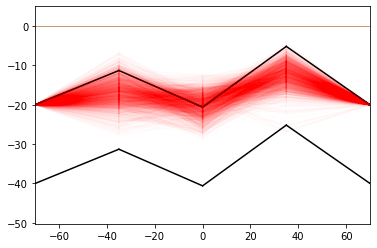

In [31]:
draw_MCMC(points,accepted_samples[:,:,0],Truth=True_position) # [:,:,0] transpost the results for plotting

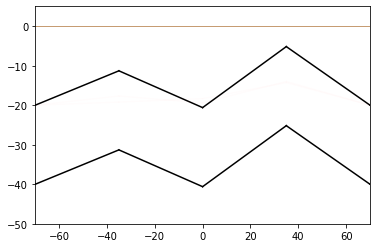

In [32]:
draw_MCMC(points,accepted_samples[0:2,:,0],Truth=True_position)

In [33]:
points

<tf.Variable 'Variable:0' shape=(14, 2) dtype=float32, numpy=
array([[-200.      ,  -40.      ],
       [ -70.      ,  -40.      ],
       [ -35.      ,  -39.212463],
       [   0.      ,  -38.33638 ],
       [  35.      ,  -34.293606],
       [  70.      ,  -40.      ],
       [ 200.      ,  -40.      ],
       [ 200.      ,  -20.      ],
       [  70.      ,  -20.      ],
       [  35.      ,  -14.293606],
       [   0.      ,  -18.336382],
       [ -35.      ,  -19.212463],
       [ -70.      ,  -20.      ],
       [-200.      ,  -20.      ]], dtype=float32)>

In [54]:
True_position

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([ -5.1785946, -20.606672 , -11.302174 ], dtype=float32)>

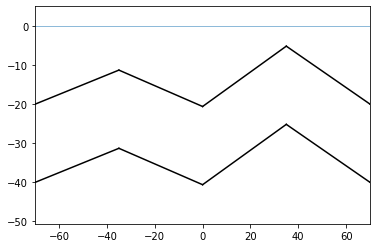

In [35]:
draw(points,True_position,R=70)

# Hessian Method

In [38]:
with tf.GradientTape() as t:  
    t.watch(points)
    loss = tf.negative(joint_log_prob(D,points,MAP)) # negative log posterior
    dlossdmu = t.gradient(loss,points)
    print(dlossdmu)

tf.Tensor(
[[ 0.04491242  0.01316353]
 [-0.0053577   0.0583462 ]
 [-0.00584992  0.02409294]
 [-0.00113579 -0.04252679]
 [ 0.01301334  0.01967661]
 [ 0.00912798  0.05072638]
 [-0.04591475  0.01091762]
 [ 0.04491242 -0.00728843]
 [-0.0223182  -0.08244012]
 [-0.04054962 -0.09202901]
 [-0.01056352  0.1373597 ]
 [ 0.01582097 -0.07725944]
 [ 0.01163589 -0.08546148]
 [-0.04371582 -0.0087679 ]], shape=(14, 2), dtype=float32)


In [39]:
with tf.GradientTape() as t:
    with tf.GradientTape() as tt:
        tt.watch(points)
        loss = tf.negative(joint_log_prob(D,points,MAP))
    jac = tt.gradient(loss,points)
hess = t.jacobian(jac,points)

In [40]:
print(hess)

tf.Tensor(
[[[[ 6.40909791e-01  8.71179998e-02]
   [-2.67109200e-02  3.03733915e-01]
   [ 4.21840698e-04  3.31570625e-01]
   [-2.88295709e-02  3.70260924e-01]
   [-6.09306013e-03  3.49520862e-01]
   [ 5.04545718e-02  3.06818187e-01]
   [-6.50966883e-01  8.70167091e-02]
   [ 6.40640140e-01 -5.00468463e-02]
   [-6.17419668e-02 -2.82925338e-01]
   [ 4.84523736e-03 -4.56661701e-01]
   [ 3.82574648e-02 -4.69223678e-01]
   [ 1.61077827e-04 -4.29877430e-01]
   [ 3.20324302e-02 -2.76228487e-01]
   [-6.30583048e-01 -5.00468276e-02]]

  [[ 8.71179998e-02  1.49788484e-02]
   [-4.73164720e-03  5.61065935e-02]
   [-7.58800248e-04  5.53234294e-02]
   [-2.51848786e-03  4.74364497e-02]
   [-1.42487662e-03  3.43465395e-02]
   [ 4.62728366e-03  2.93406900e-02]
   [-8.81872997e-02  9.17496346e-03]
   [ 8.70167315e-02 -5.09153539e-03]
   [-4.67644492e-03 -2.32761949e-02]
   [ 1.81212579e-03 -3.83428298e-02]
   [ 2.58851610e-03 -5.76060116e-02]
   [ 1.95259007e-03 -7.82641843e-02]
   [ 6.98353816e-03 -5.78

In [41]:
HessMatrix = np.empty(shape = [Number_para,Number_para])
for x,i1 in enumerate(range(Number_para+6,2*Number_para+6)):
    for y,i2 in enumerate(range(Number_para+6,2*Number_para+6)):
        HessMatrix[x,y] = hess[i1,1,i2,1]

In [42]:
print(HessMatrix)

[[0.62371027 0.32679853 0.10340066]
 [0.32679856 0.47970247 0.3034977 ]
 [0.10340068 0.30349764 0.48563412]]


In [96]:
def Laplace_appro(H,C_prior):
    return tf.linalg.inv((tf.add(H,tf.linalg.inv(C_prior))))


In [99]:
cov_post = Laplace_appro(HessMatrix,cov_prior)

In [100]:
cov_post

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[ 2.2091596, -1.6563011,  0.5120193],
       [-1.656301 ,  4.037153 , -1.9677684],
       [ 0.5120189, -1.9677678,  2.8830686]], dtype=float32)>

In [101]:
@tf.function
def matrixcompute(matrix1,matrix2,Cov):
    matrix1 = tf.cast(matrix1,tf.float32)
    matrix2 = tf.cast(matrix2,tf.float32)
    matrix = tf.subtract(matrix1, matrix2)
    matrix = tf.reshape(matrix,[matrix.shape[0],1])
    matrix_T = tf.transpose(matrix)
    Cov_inv = tf.linalg.inv(Cov)
    result = tf.multiply(tf.constant(1/2),tf.matmul(tf.matmul(matrix_T,Cov_inv),matrix))
    return result

def acceptance_gpCN(m_current , m_proposed):
    delta_current = tf.subtract(negative_log_post(m_current),matrixcompute(m_current,MAP,cov_post))
    delta_proposed = tf.subtract(negative_log_post(m_proposed),matrixcompute(m_proposed,MAP,cov_post))

    ## calculate accept ratio if exp()<1
    accept_ratio = tf.exp(tf.subtract(delta_current,delta_proposed))
    acceptsample = tfd.Sample(
    tfd.Uniform(0., 1.),
    sample_shape=[1,1])
    sample = acceptsample.sample()
    
    if(accept_ratio > sample):
        return True
    else:
        return False
        
from IPython.display import clear_output
# define leaning rate
beta = 0.4

@tf.function
def draw_proposal(m_current):
    
    _term1 = MAP
    
    ## sqrt term
    tem_1 = tf.convert_to_tensor(tf.sqrt(1-beta**2),dtype = tf.float32)
    ## sqrt(1-beta^2)()
    _term2 = tf.multiply(tem_1,(tf.subtract(m_current,MAP)))
    
    Xi = tfd.MultivariateNormalFullCovariance(
            loc = 0,
            covariance_matrix= cov_post)

    Xi_s = tfd.Sample(Xi)
    _term3 = tf.multiply(beta,Xi_s.sample())
    
    m_proposed = tf.add(MAP,tf.add(_term2,_term3))
    
    return m_proposed       

In [102]:
draw_proposal(MAP)

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([ -6.25108 , -18.79881 , -11.842674], dtype=float32)>

In [103]:
def negative_log_post(mu):
    return(tf.negative(joint_log_prob(D,points,mu)))

In [104]:
mu_init = [-2.,-2.,-4.]

number_of_steps = 2000
def run_chain():
    burn_in = 1000
    steps = number_of_steps
    k = 0
    accepted = []
    rejected = []

    m_current = mu_init  # init m
    
    
    for k in range(steps+burn_in):

        m_proposed = draw_proposal(m_current)

        
        if acceptance_gpCN(m_current,m_proposed):
            m_current = m_proposed
            if k > burn_in:
                accepted.append(m_proposed.numpy())
        else:
            m_current = m_current
            rejected.append(m_proposed.numpy())
    
    return accepted,rejected
#     print("acceptance rate = %0.1f%%", 100*np.shape(accepted)[0]/steps)
    
accepted,rejected = run_chain()
np.shape(accepted)[0]
print('Acceptance rate = %0.1f%%' % (100*np.shape(accepted)[0]/number_of_steps))

accepted = np.array(accepted)



Acceptance rate = 0.0%


gpCN seems not quite correct, the reason is demonstrated below in DEBUG:

-  the main reason it's failed is the acceptence rate: negative log post minus the diff in $m_v$ makes the good proposal have big $\Delta$

let's try pCN first

In [105]:
cov_post

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[ 2.2091596, -1.6563011,  0.5120193],
       [-1.656301 ,  4.037153 , -1.9677684],
       [ 0.5120189, -1.9677678,  2.8830686]], dtype=float32)>

In [58]:
cov_prior

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[20.,  0.,  0.],
       [ 0., 20.,  0.],
       [ 0.,  0., 20.]], dtype=float32)>

### try pCN MCMC

first define a likelihood function rather than posteior function

In [162]:
def likelihood(D,points_copy,ps):

    Gm_ = grav(points_copy,ps)
    
    mvn_likelihood = tfd.MultivariateNormalFullCovariance(
            loc = Gm_,
            covariance_matrix= cov)
    
    return mvn_likelihood.log_prob(D)

def negative_likeli(D,points,ps):
    return tf.negative(likelihood(D,points,ps))

In [164]:
negative_likeli(D,points,m_test)

<tf.Tensor: shape=(), dtype=float32, numpy=-113.3639>

In [165]:
def acceptance_pCN(m_current , m_proposed):
    delta_current = negative_likeli(D,points,m_current)
    delta_proposed = negative_likeli(D,points,m_proposed)
    ## calculate accept ratio if exp()<1
    accept_ratio = tf.exp(tf.subtract(delta_current,delta_proposed))
    acceptsample = tfd.Sample(
    tfd.Uniform(0., 1.),
    sample_shape=[1,1])
    sample = acceptsample.sample()
    
    if(accept_ratio > sample):
        return True
    else:
        return False

In [168]:
mu_init = [-2.,-2.,-4.]

number_of_steps = 2000
def run_chain():
    burn_in = 1000
    steps = number_of_steps
    k = 0
    accepted = []
    rejected = []

    m_current = mu_init  # init m
    
    for k in range(steps+burn_in):

        m_proposed = draw_proposal(m_current)

        if acceptance_pCN(m_current,m_proposed):
            m_current = m_proposed
            if k > burn_in:
                accepted.append(m_proposed.numpy())
        else:
            m_current = m_current
            rejected.append(m_proposed.numpy())
    
    return accepted,rejected
#     print("acceptance rate = %0.1f%%", 100*np.shape(accepted)[0]/steps)
    
accepted,rejected = run_chain()
np.shape(accepted)[0]
print('Acceptance rate = %0.1f%%' % (100*np.shape(accepted)[0]/number_of_steps))

accepted = np.array(accepted)

Acceptance rate = 94.5%


### Debug|

In [ ]:
mu_init = [-2.,-2.,-4.]

number_of_steps = 10

burn_in = 5
steps = number_of_steps
k = 0
accepted = []
rejected = []

m_current = mu_init  # init m
    
    
for k in range(steps+burn_in):

    m_proposed = draw_proposal(m_current)

    if acceptance_gpCN(m_current,m_proposed):
        m_current = m_proposed
        if k > burn_in:
            accepted.append(m_proposed.numpy())
    else:
        m_current = m_current
        rejected.append(m_proposed.numpy())
    


In [106]:
MAP

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([ -6.1381764, -18.831266 , -12.485522 ], dtype=float32)>

In [117]:
m1 = draw_proposal(MAP)

In [122]:
m_test = tf.constant([-1.,-10.,-2.])

In [123]:
acceptance_gpCN(MAP,m_test)

True

In [119]:
def acceptance_pCN(m_current , m_proposed):
    delta_current = tf.subtract(negative_log_post(m_current),matrixcompute(m_current,MAP,cov_post))
    delta_proposed = tf.subtract(negative_log_post(m_proposed),matrixcompute(m_proposed,MAP,cov_post))

    ## calculate accept ratio if exp()<1
    accept_ratio = tf.exp(tf.subtract(delta_current,delta_proposed))
    acceptsample = tfd.Sample(
    tfd.Uniform(0., 1.),
    sample_shape=[1,1])
    sample = acceptsample.sample()
    
    if(accept_ratio > sample):
        return True
    else:
        return False

In [155]:
negative_log_post(MAP)

<tf.Tensor: shape=(), dtype=float32, numpy=-108.65752>

In [156]:
negative_log_post(m_test)

<tf.Tensor: shape=(), dtype=float32, numpy=-86.48848>

In [146]:
m_current =  m_test
m_proposed = MAP

delta_current = tf.subtract(negative_log_post(m_current),matrixcompute(m_current,MAP,cov_post))
delta_proposed = tf.subtract(negative_log_post(m_proposed),matrixcompute(m_proposed,MAP,cov_post))
accept_ratio = tf.exp(tf.subtract(delta_current,delta_proposed))

In [157]:
delta_current

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-193.98718]], dtype=float32)>

In [158]:
delta_proposed

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-108.65752]], dtype=float32)>